1/1 [==============================] - 0s 214ms/step


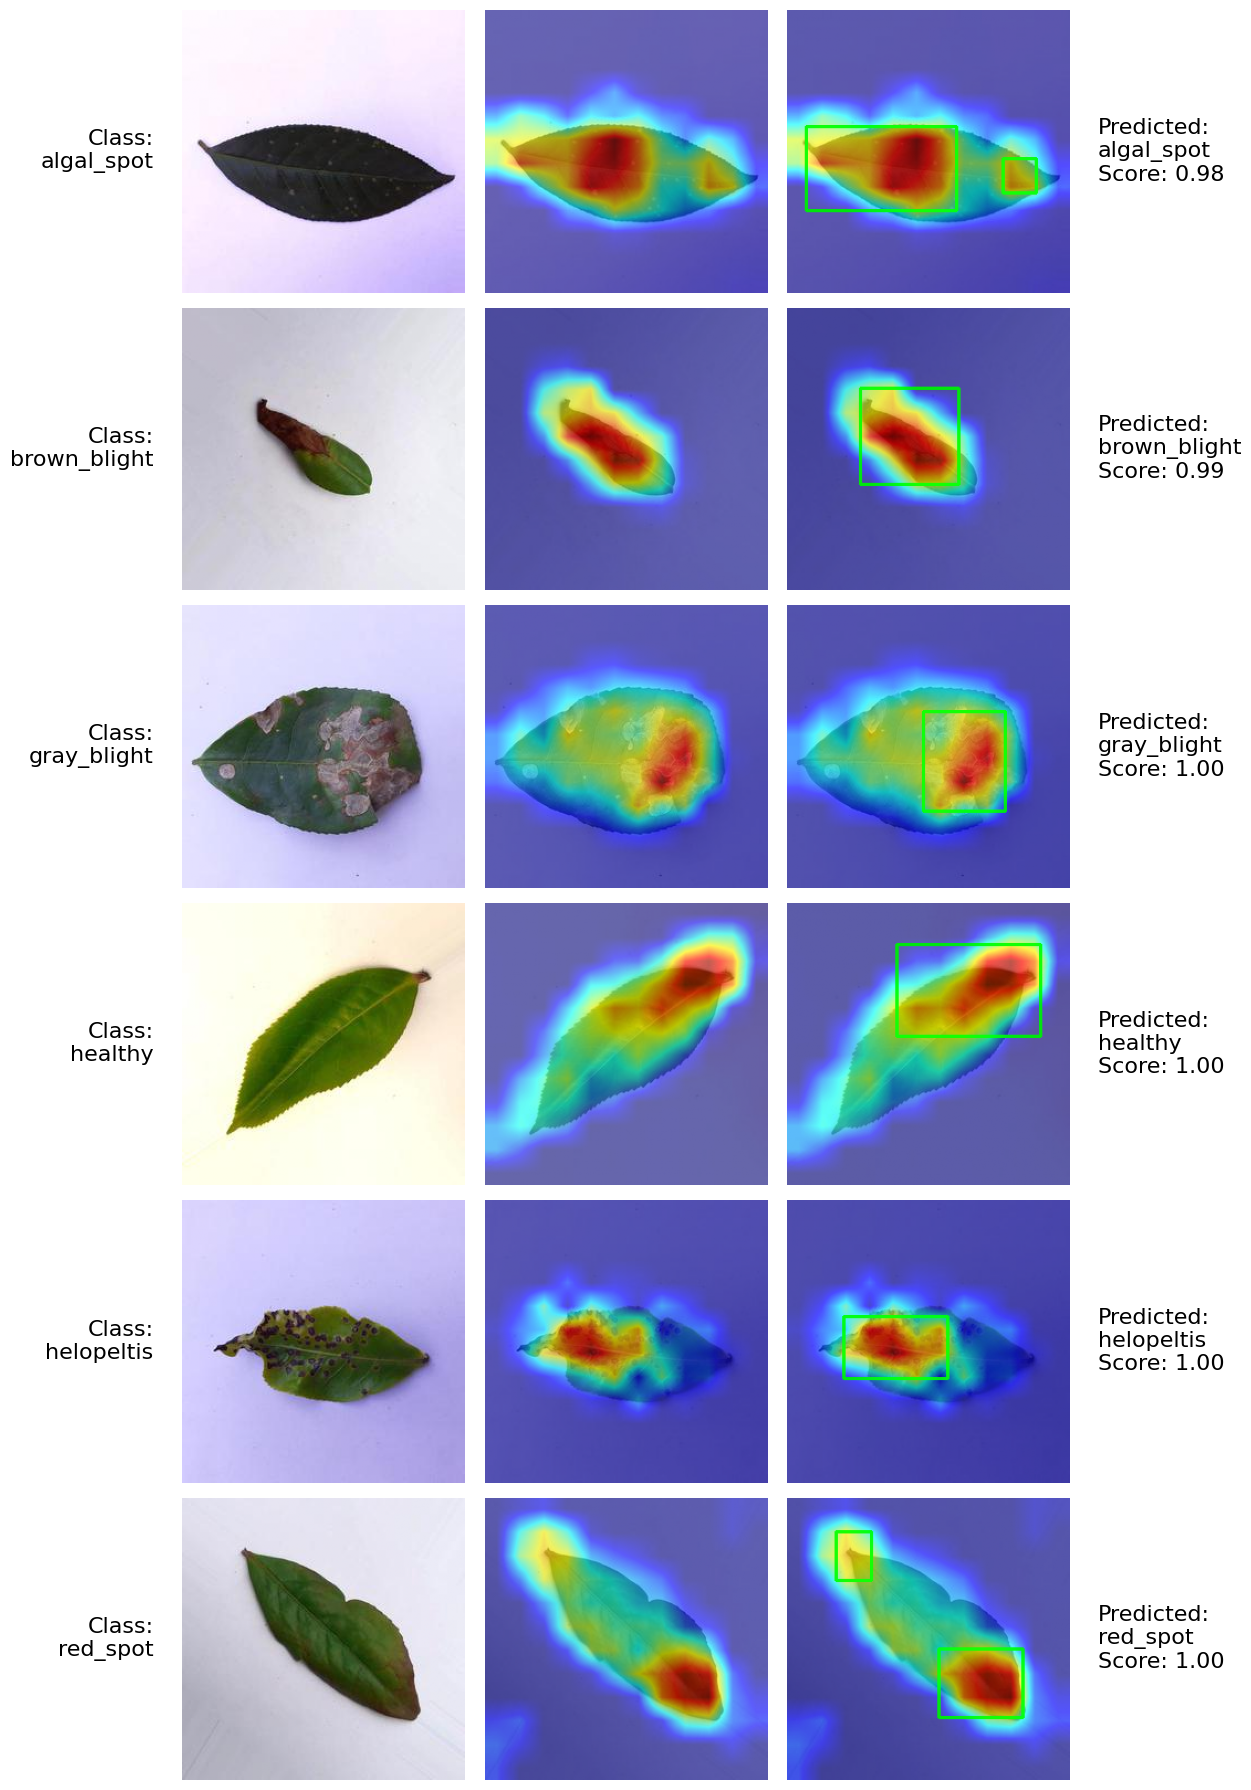

In [3]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2

# Fungsi untuk memuat dan memproses gambar
def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

# Fungsi untuk membuat heatmap Grad-CAM
def make_gradcam_heatmap(img_array, model, class_index):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer("top_activation").output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]
    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs[0]), axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)
    return heatmap.numpy()

# Fungsi untuk menggabungkan heatmap dengan gambar asli dengan transparansi
def overlay_heatmap(img, heatmap, alpha=0.6):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = heatmap[:, :, [2, 1, 0]]
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return superimposed_img

# Fungsi untuk menggambar kotak di area yang dideteksi
def draw_bounding_box(img, heatmap, threshold=0.6):
    # Menentukan batas atas dari heatmap
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    _, heatmap_thresholded = cv2.threshold(heatmap_resized, threshold * 255, 255, cv2.THRESH_BINARY)

    # Temukan kontur dari area yang memiliki nilai tertinggi
    contours, _ = cv2.findContours(heatmap_thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        if cv2.contourArea(contour) > 100:  # Filter untuk area kecil (noise)
            # Menggambar bounding box di sekitar area yang ditemukan
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Kotak hijau
    return img

# Memuat model yang sudah dilatih
best_model = load_model('Best model tunning/best_model_neuron_256.keras')
model = best_model.get_layer('efficientnetv2-s')  # Mengambil lapisan yang tepat

# Mengatur path ke folder dataset
base_path = 'archive_grad_map'
classes = os.listdir(base_path)

# Menyimpan gambar yang dipilih dan kelasnya
random_images = []
class_names = []

# Mengambil gambar acak dari masing-masing kelas
for class_name in classes:
    class_path = os.path.join(base_path, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        random_image = random.choice(images)
        random_images.append(os.path.join(class_path, random_image))
        class_names.append(class_name)

# Memproses dan menyimpan semua gambar dalam satu figure
num_images = len(random_images)

# Pastikan ukuran figure besar
fig, axes = plt.subplots(num_images, 3, figsize=(12.5, 3 * num_images))

for i, img_path in enumerate(random_images):
    try:
        img_array = get_img_array(img_path, size=(384, 384))

        # Melakukan prediksi
        predictions = best_model.predict(img_array)
        class_index = np.argmax(predictions[0])
        class_score = predictions[0][class_index]
        predicted_class = classes[class_index]

        # Menghasilkan heatmap Grad-CAM
        heatmap = make_gradcam_heatmap(img_array, model, class_index)

        # Membaca gambar asli
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Menggabungkan heatmap dengan gambar asli
        superimposed_img = overlay_heatmap(img, heatmap)

        # Menambahkan bounding box
        img_with_bbox = draw_bounding_box(superimposed_img.copy(), heatmap)

        # Plot gambar asli
        axes[i, 0].imshow(img / 255)
        axes[i, 0].axis('off')
        axes[i, 0].text(-0.1, 0.5, f'Class:\n{class_names[i]}', fontsize=16, ha='right', va='center', transform=axes[i, 0].transAxes)

        # Plot gambar dengan heatmap
        axes[i, 1].imshow(superimposed_img / 255)
        axes[i, 1].axis('off')

        # Plot gambar dengan bounding box
        img_with_bbox_transparent = overlay_heatmap(img_with_bbox, heatmap, alpha=0.1)
        axes[i, 2].imshow(img_with_bbox_transparent / 255)
        axes[i, 2].axis('off')
        axes[i, 2].text(1.1, 0.5, f'Predicted:\n{predicted_class}\nScore: {class_score:.2f}', fontsize=16, ha='left', va='center', transform=axes[i, 2].transAxes)
    
    except Exception as e:
        print(f"Error processing image {img_path}: {e}")

plt.tight_layout()
plt.show()
